# scANVI integration of disease dataset
- Reran scvi without study as a categorical covariate as this currently isn't handled by scArches 
'''./run_scvi_adsaves.py --n-hvg 7500 \
            --remove-from-hvg feature_list/cc_genes.csv \
            --batch donorID_unified \
            --min-batch-size 0 \
            --continuous log1p_n_counts,percent_mito \
            --train-reference \
            ~/Annotations_v3/pooled_healthy.gene_cellbender.good_qc_cluster_mito80.raw.subsetted.manual_doublet_removed.fine_annot.20230110.h5ad \
            ~/Annotations_v3/scvi_output20230116/pooled_healthy.hvg7500_noCC.nodoublets.scvi_output.20230113
- Then used this notebook (from Ni) to run scANVI 
- Adapt predictions to run from KNN graph rather than genes based on HLCA code: https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/scripts/label_transfer.py


# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib

import numpy as np
import numpy_groupies as npg
import scipy.sparse as sp
import pandas as pd
from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap, LogNorm

import seaborn as sn

import anndata

import scanpy as sc
import sctk as sk

import torch
import scvi


from collections import Counter

import numpy as np
from sklearn.neighbors import KNeighborsTransformer

Global seed set to 0


In [2]:
rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)
sc.settings.verbosity = 0
sk.set_figsize((4, 4))
#torch.cuda.set_device(1)

#PYTHON = "/software/team205/miniconda3/envs/rapids-torch/bin/python"

#%cd ~/scratch/20220125_digestive_tract_integration/v2/

# Define functions

In [3]:
def weighted_knn_trainer(train_adata, train_adata_emb, label_key, n_neighbors=50):
    """Trains a weighted KNN classifier on ``train_adata``.
    Parameters
    ----------
    train_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to train KNN classifier with ``label_key`` as the target variable.
    train_adata_emb: str
        Name of the obsm layer to be used for calculation of neighbors. If set to "X", anndata.X will be
        used
    label_key: str
        Name of the column to be used as target variable (e.g. cell_type) in ``train_adata`` and ``query_adata``.
    n_neighbors: int
        Number of nearest neighbors in KNN classifier.
    """
    print(
        f"Weighted KNN with n_neighbors = {n_neighbors} ... ",
        end="",
    )
    k_neighbors_transformer = KNeighborsTransformer(
        n_neighbors=n_neighbors,
        mode="distance",
        algorithm="brute",
        metric="euclidean",
        n_jobs=-1,
    )
    if train_adata_emb == "X":
        train_emb = train_adata.X
    elif train_adata_emb in train_adata.obsm.keys():
        train_emb = train_adata.obsm[train_adata_emb]
    else:
        raise ValueError(
            "train_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    k_neighbors_transformer.fit(train_emb)
    return k_neighbors_transformer

In [4]:
def weighted_knn_transfer(
    query_adata,
    query_adata_emb,
    ref_adata_obs,
    label_keys,
    knn_model,
    threshold=1,
    pred_unknown=False,
    mode="package",
):
    """Annotates ``query_adata`` cells with an input trained weighted KNN classifier.
    Parameters
    ----------
    query_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to queryate KNN classifier. Embedding to be used
    query_adata_emb: str
        Name of the obsm layer to be used for label transfer. If set to "X",
        query_adata.X will be used
    ref_adata_obs: :class:`pd.DataFrame`
        obs of ref Anndata
    label_keys: str
        Names of the columns to be used as target variables (e.g. cell_type) in ``query_adata``.
    knn_model: :class:`~sklearn.neighbors._graph.KNeighborsTransformer`
        knn model trained on reference adata with weighted_knn_trainer function
    threshold: float
        Threshold of uncertainty used to annotating cells as "Unknown". cells with
        uncertainties higher than this value will be annotated as "Unknown".
        Set to 1 to keep all predictions. This enables one to later on play
        with thresholds.
    pred_unknown: bool
        ``False`` by default. Whether to annotate any cell as "unknown" or not.
        If `False`, ``threshold`` will not be used and each cell will be annotated
        with the label which is the most common in its ``n_neighbors`` nearest cells.
    mode: str
        Has to be one of "paper" or "package". If mode is set to "package",
        uncertainties will be 1 - P(pred_label), otherwise it will be 1 - P(true_label).
    """
    if not type(knn_model) == KNeighborsTransformer:
        raise ValueError(
            "knn_model should be of type sklearn.neighbors._graph.KNeighborsTransformer!"
        )

    if query_adata_emb == "X":
        query_emb = query_adata.X
    elif query_adata_emb in query_adata.obsm.keys():
        query_emb = query_adata.obsm[query_adata_emb]
    else:
        raise ValueError(
            "query_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    top_k_distances, top_k_indices = k_neighbors_transformer.kneighbors(X=query_emb)

    stds = np.std(top_k_distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)

    top_k_distances_tilda = np.exp(-np.true_divide(top_k_distances, stds))

    weights = top_k_distances_tilda / np.sum(
        top_k_distances_tilda, axis=1, keepdims=True
    )
    cols = ref_adata_obs.columns[ref_adata_obs.columns.str.startswith(label_keys)]
    uncertainties = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    pred_labels = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    for i in range(len(weights)):
        for j in cols:
            y_train_labels = ref_adata_obs[j].values
            unique_labels = np.unique(y_train_labels[top_k_indices[i]])
            best_label, best_prob = None, 0.0
            for candidate_label in unique_labels:
                candidate_prob = weights[
                    i, y_train_labels[top_k_indices[i]] == candidate_label
                ].sum()
                if best_prob < candidate_prob:
                    best_prob = candidate_prob
                    best_label = candidate_label

            if pred_unknown:
                if best_prob >= threshold:
                    pred_label = best_label
                else:
                    pred_label = "Unknown"
            else:
                pred_label = best_label

            if mode == "package":
                uncertainties.iloc[i][j] = (max(1 - best_prob, 0))

            else:
                raise Exception("Inquery Mode!")

            pred_labels.iloc[i][j] = (pred_label)

    print("finished!")

    return pred_labels, uncertainties

# Load data

In [5]:
#output from scvi run, used to mask adata so that genes match up with scvi HVG
ad_output = sc.read_h5ad('/home/jupyter/Annotations_v3/scvi_output20230126/pooled_healthy.hvg7500_noCC.nodoublets.scvi_output.20230126-ad1.h5ad')

In [6]:
#output from CPU notebook with scvi coordinates and UMAP
adata = sc.read_h5ad('/home/jupyter/Annotations_v3/h5ad/post_scvi20230126/pooled_healthy.hvg7500_noCC.scvi_output_nocatcovar.fine_annot.20230126.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 1077241 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_s

In [8]:
ad_output

AnnData object with n_obs × n_vars = 1077241 × 7280
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [9]:
adata = adata[:, adata.var_names.isin(ad_output.var_names)].copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 1077241 × 7280
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

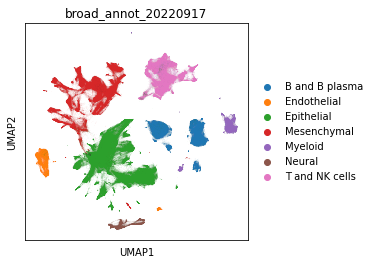

In [11]:
sc.pl.umap(adata,color='broad_annot_20220917')

In [13]:
#load reference that was run without study as a categorical co-variate
scvi_ref = scvi.model.SCVI.load("/home/jupyter/Annotations_v3/scvi_output20230126/pooled_healthy.hvg7500_noCC.nodoublets.scvi_output.20230126.vae/",adata)

INFO     File /home/jupyter/Annotations_v3/scvi_output20230126/pooled_healthy.hvg7500_noCC.no
         doublets.scvi_output.20230126.vae/model.pt already downloaded                       


# Process

## Train
Trains a SCANVI model based on the scvi model

In [14]:
scvi_ref

SCVI Model with the following params: 
n_hidden: 128, n_latent: 20, n_layers: 2, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [15]:
scvi_ref.adata

AnnData object with n_obs × n_vars = 1077241 × 7280
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [16]:
scvi_ref.adata.obs.columns

Index(['latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH',
       'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL',
       'cecilia22_predL_prob', 'cecilia22_predL_uncertain',
       'elmentaite21_pred', 'elmentaite21_pred_prob',
       ...
       'martin19_pred', 'martin19_pred_prob', 'martin19_pred_uncertain',
       'warner20_pred', 'warner20_pred_prob', 'warner20_pred_uncertain',
       'broad_annot_20220917', 'donor_organ_lineage', 'fine_annot',
       'fine_annot_original'],
      dtype='object', length=116)

In [17]:
scanvi_ref = scvi.model.SCANVI.from_scvi_model(
    scvi_ref, unlabeled_category="Unknown", labels_key="broad_annot_20220917"
)

In [18]:
scanvi_ref.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                             


/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/jupyter/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 20/20: 100%|██████████| 20/20 [56:27<00:00, 169.38s/it, loss=889, v_num=1]


In [19]:
scanvi_ref

ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 20, n_layers: 2, dropout_rate: 0.2, 
dispersion: gene, gene_likelihood: zinb
Training status: Trained

In [20]:
scanvi_ref.save(
    "/home/jupyter/Annotations_v3/models/scanvi_output20230126/pooled_healthy.broad_annot_20220817.scanvi_model.pt"
)

In [21]:
scanvi_ref.adata

AnnData object with n_obs × n_vars = 1077241 × 7280
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [22]:
scanvi_ref.adata.obsm["X_scANVI"] = scanvi_ref.get_latent_representation()

In [38]:
scanvi_ref.adata

AnnData object with n_obs × n_vars = 1077241 × 7280
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [ ]:
pd.DataFrame(
    scanvi_ref.adata.obsm["X_scANVI"],
    index=scanvi_ref.adata.obs_names,
    columns=[f"LV{i+1}" for i in range(scanvi_ref.adata.obsm["X_scANVI"].shape[1])],
).to_csv(
    "/home/jupyter/Annotations_v3/models/scanvi_20230126/pooled_healthy.scanvi_broad_annot.X_scANVI.20230126.csv.gz"
)

In [ ]:
for ct in adata.obs.broad_annot_20220917.unique():
    sk.clear_colors(scanvi_ref.adata)
    sk.plot_embedding(
        scanvi_ref.adata[scanvi_ref.adata.obs.broad_annot_20220917 == ct],
        basis="umap",
        groupby="fine_annot",
        annot="full",
        title=ct,
        figsize=(12, 12),
    );

## Query
Use SCANVI 

In [5]:
adata = sc.read_h5ad('/home/jupyter/Annotations_v3/h5ad/post_scvi20230126/pooled_healthy.hvg7500_noCC.scvi_output_nocatcovar.fine_annot.20230126.h5ad')

In [6]:
ad_output = sc.read_h5ad('/home/jupyter/Annotations_v3/scvi_output20230126/pooled_healthy.hvg7500_noCC.nodoublets.scvi_output.20230126-ad1.h5ad')

In [7]:
adata = adata[:, adata.var_names.isin(ad_output.var_names)].copy()

In [9]:
adata.obsm['X_scANVI'] = pd.read_csv("/home/jupyter/Annotations_v3/models/scanvi_20230126/pooled_healthy.scanvi_broad_annot.X_scANVI.20230126.csv.gz", compression='gzip',index_col=0)

In [10]:
adata.obsm['X_scANVI']

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,LV11,LV12,LV13,LV14,LV15,LV16,LV17,LV18,LV19,LV20
index,,,,,,,,,,,,,,,,,,,,
AAACGAATCTCTTGCG-GSM4600896,-0.262764,1.340677,-2.160902,0.069910,0.357158,-0.287108,-0.965917,0.034153,0.520506,-1.790125,-2.397438,0.138315,1.872088,0.020697,1.892465,-1.511135,0.019417,0.131700,-0.495227,-0.556520
AAACGCTAGCGACCCT-GSM4600896,-0.072241,-0.613696,-1.073295,0.022658,-0.044960,-2.545102,2.844645,0.187638,1.874540,0.084587,0.673198,0.001966,1.555422,0.085497,-0.334869,-1.109183,-0.238280,0.009870,1.183070,-0.461780
AAAGAACAGCGACCCT-GSM4600896,-0.186965,0.732935,-3.169084,0.021434,-0.143460,1.466100,-0.358301,0.016458,-0.353812,-1.221823,-2.798178,0.058806,2.864401,0.021629,-0.075594,-1.860333,-0.053360,0.139438,0.201179,0.432220
AAAGGGCAGTCACACT-GSM4600896,-0.214525,0.690759,-1.187455,0.021666,-0.333761,-2.460742,2.626953,0.113892,1.936636,0.166195,0.925668,0.042487,1.396114,0.062435,-0.161051,-1.128958,-0.226845,0.067524,1.113563,-0.178845
AAAGGGCCAACACAGG-GSM4600896,-0.132387,0.666024,-2.914824,0.050465,-0.749595,-1.104950,0.792894,0.157958,-1.469138,0.220614,-0.774842,0.057308,3.286594,0.115430,0.791877,1.670156,-0.374083,0.084604,3.532067,-0.859793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGAACAACT-GSM5525958,-0.082769,0.065547,0.018543,0.025168,0.171616,0.287131,0.165565,0.105013,2.332270,0.280057,-1.596661,0.070707,1.596012,-0.017695,-0.493651,1.424329,-0.008835,0.028931,0.241978,0.316227
TTTGTCAAGATAGGAG-GSM5525958,-0.089325,0.314489,0.136367,-0.003346,-0.200382,0.061592,0.648185,0.115966,-1.006780,0.291699,2.153949,-0.020209,1.295467,-0.091060,-0.919412,0.742865,0.037235,0.024060,0.007070,-0.251480
TTTGTCAAGTAGGCCA-GSM5525958,-0.132377,0.496524,0.069856,-0.000387,-0.512903,-0.079071,0.597407,0.104690,-1.041012,0.328690,1.783911,-0.035832,1.460910,-0.092021,-0.789184,1.106185,-0.010677,0.053218,-0.306778,-0.069698


In [11]:
disease_ad = sc.read('/home/jupyter/Annotations_v3/h5ad/pooled_disease.gene_cellbender.good_qc_cluster_mito80.stringent_doublet_removed.hvg7500_noCC.scvi_output.lv20_batch256.with_broad_annotation.20220930.h5ad')

In [12]:
disease_ad

AnnData object with n_obs × n_vars = 299041 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [13]:
disease_ad.obs

,latent_cell_probability,latent_RT_efficiency,cecilia22_predH,cecilia22_predH_prob,cecilia22_predH_uncertain,cecilia22_predL,cecilia22_predL_prob,cecilia22_predL_uncertain,elmentaite21_pred,elmentaite21_pred_prob,...,doublet,stringent_doublet,_scvi_batch,_scvi_labels,martin19_pred,martin19_pred_prob,martin19_pred_uncertain,warner20_pred,warner20_pred_prob,warner20_pred_uncertain
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAGGTTAT-4918STDY7273964,0.999636,1.277868,B cells,0.999935,B cells,Naive B cells,0.532800,Naive B cells,Naive B,0.997290,...,False,False,181,0,B naive,0.733306,B naive,Th,0.269990,Uncertain
AAACCTGAGGCCCTCA-4918STDY7273964,0.999551,1.287072,T cells,0.999993,T cells,Tcm/Naive helper T cells,0.186769,Uncertain,SELL+ CD4 T,0.260945,...,False,False,181,0,T CD8 naive,0.846878,T CD8 naive,Th,0.597118,Th
AAACCTGTCCAAACTG-4918STDY7273964,0.999662,1.191093,T cells,0.999954,T cells,Tcm/Naive helper T cells,0.977933,Tcm/Naive helper T cells,SELL+ CD4 T,0.993349,...,False,False,181,0,T CD4 naive,0.883033,T CD4 naive,Th,0.757285,Th
AAACGGGAGAGCTGGT-4918STDY7273964,0.999145,1.139521,B cells,0.999925,B cells,Naive B cells,0.999827,Naive B cells,Naive B,0.990829,...,False,False,181,0,B naive,0.956381,B naive,Th,0.298665,Uncertain
AAACGGGCACTAAGTC-4918STDY7273964,0.999503,1.281189,B cells,0.999567,B cells,Naive B cells,0.964691,Naive B cells,Naive B,0.998023,...,False,False,181,0,B naive,0.974881,B naive,Th,0.355680,Th
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCAGGTTCA-GSM4546346,0.999940,2.888317,Epithelial cells,0.025135,Uncertain,Epithelial cells,0.095139,Uncertain,Microfold cell,0.997442,...,False,False,126,0,Epi cycling,0.583857,Epi cycling,Mucous Acini,0.402162,Mucous Acini
TTTGTCAGTCGCCATG-GSM4546346,0.999626,1.551974,Macrophages,0.362724,Macrophages,Intermediate macrophages,0.163352,Uncertain,Monocytes,0.169558,...,False,False,126,0,nrMac,0.527260,nrMac,DC2,0.815706,DC2
TTTGTCAGTGGTGTAG-GSM4546346,0.999744,1.542765,T cells,0.000322,Uncertain,NK cells,0.001026,Uncertain,Pericyte,0.999998,...,False,False,126,0,Pericyte,0.979788,Pericyte,SM,0.419596,SM


In [14]:
disease_ad = disease_ad[:, disease_ad.var_names.isin(adata.var_names)].copy()

In [15]:
disease_ad

AnnData object with n_obs × n_vars = 299041 × 7280
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [16]:
scanvi_query = scvi.model.SCANVI.load_query_data(
    disease_ad,
    "/home/jupyter/Annotations_v3/models/scanvi_output20230126/pooled_healthy.broad_annot_20220817.scanvi_model.pt",
)

INFO     File /home/jupyter/Annotations_v3/models/scanvi_output20230126/pooled_healthy.broad_
         annot_20220817.scanvi_model.pt/model.pt already downloaded                          


/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:89: UserWarning: Missing labels key broad_annot_20220917. Filling in with unlabeled category Unknown.
  warnings.warn(


In [17]:
scanvi_query.train(
    max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10
)

INFO     Training for 100 epochs.                                                            


/opt/conda/envs/scvi/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/jupyter/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/100:   1%|          | 1/100 [00:38<1:04:01, 38.80s/it, loss=583, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/100:   2%|▏         | 2/100 [01:16<1:02:35, 38.32s/it, loss=570, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/100:   3%|▎         | 3/100 [01:54<1:01:27, 38.02s/it, loss=571, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/100:   4%|▍         | 4/100 [02:32<1:01:02, 38.15s/it, loss=565, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/100:   5%|▌         | 5/100 [03:10<59:53, 37.83s/it, loss=569, v_num=1]  

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/100:   6%|▌         | 6/100 [03:47<58:57, 37.63s/it, loss=570, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/100:   7%|▋         | 7/100 [04:24<58:08, 37.51s/it, loss=566, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/100:   8%|▊         | 8/100 [05:01<57:08, 37.26s/it, loss=568, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/100:   9%|▉         | 9/100 [05:38<56:33, 37.29s/it, loss=563, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/100:  10%|█         | 10/100 [06:18<57:04, 38.05s/it, loss=564, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 12/100:  11%|█         | 11/100 [06:55<55:49, 37.64s/it, loss=565, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/100:  12%|█▏        | 12/100 [07:32<55:00, 37.50s/it, loss=571, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 14/100:  13%|█▎        | 13/100 [08:09<54:05, 37.30s/it, loss=563, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/100:  14%|█▍        | 14/100 [08:46<53:26, 37.29s/it, loss=571, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/100:  15%|█▌        | 15/100 [09:23<52:46, 37.25s/it, loss=574, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/100:  16%|█▌        | 16/100 [10:00<51:58, 37.13s/it, loss=564, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 18/100:  17%|█▋        | 17/100 [10:37<51:16, 37.06s/it, loss=572, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/100:  18%|█▊        | 18/100 [11:14<50:33, 36.99s/it, loss=561, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/100:  19%|█▉        | 19/100 [11:50<49:42, 36.82s/it, loss=574, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/100:  20%|██        | 20/100 [12:30<50:15, 37.69s/it, loss=568, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/100:  21%|██        | 21/100 [13:06<49:10, 37.35s/it, loss=571, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 23/100:  22%|██▏       | 22/100 [13:44<48:35, 37.38s/it, loss=568, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/100:  23%|██▎       | 23/100 [14:21<47:50, 37.28s/it, loss=566, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/100:  24%|██▍       | 24/100 [14:57<46:57, 37.07s/it, loss=575, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 26/100:  25%|██▌       | 25/100 [15:34<46:17, 37.04s/it, loss=557, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/100:  26%|██▌       | 26/100 [16:11<45:34, 36.95s/it, loss=570, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 28/100:  27%|██▋       | 27/100 [16:47<44:41, 36.73s/it, loss=570, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 29/100:  28%|██▊       | 28/100 [17:24<44:04, 36.73s/it, loss=564, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 30/100:  29%|██▉       | 29/100 [18:00<43:17, 36.58s/it, loss=565, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/100:  30%|███       | 30/100 [18:40<43:42, 37.46s/it, loss=571, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 32/100:  31%|███       | 31/100 [19:17<42:55, 37.32s/it, loss=564, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 33/100:  32%|███▏      | 32/100 [19:54<42:06, 37.15s/it, loss=564, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 34/100:  33%|███▎      | 33/100 [20:31<41:31, 37.19s/it, loss=568, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 35/100:  34%|███▍      | 34/100 [21:07<40:40, 36.97s/it, loss=565, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 36/100:  35%|███▌      | 35/100 [21:44<39:56, 36.87s/it, loss=575, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 37/100:  36%|███▌      | 36/100 [22:21<39:17, 36.84s/it, loss=568, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 38/100:  37%|███▋      | 37/100 [22:57<38:34, 36.73s/it, loss=564, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 39/100:  38%|███▊      | 38/100 [23:34<38:06, 36.87s/it, loss=579, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 40/100:  39%|███▉      | 39/100 [24:12<37:33, 36.95s/it, loss=564, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/100:  40%|████      | 40/100 [24:50<37:32, 37.54s/it, loss=570, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 42/100:  41%|████      | 41/100 [25:27<36:42, 37.33s/it, loss=569, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 43/100:  42%|████▏     | 42/100 [26:04<35:48, 37.04s/it, loss=580, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 44/100:  43%|████▎     | 43/100 [26:40<35:06, 36.96s/it, loss=566, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 45/100:  44%|████▍     | 44/100 [27:17<34:25, 36.89s/it, loss=574, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/100:  45%|████▌     | 45/100 [27:54<33:41, 36.75s/it, loss=562, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 47/100:  46%|████▌     | 46/100 [28:31<33:07, 36.81s/it, loss=572, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 48/100:  47%|████▋     | 47/100 [29:07<32:19, 36.59s/it, loss=572, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 49/100:  48%|████▊     | 48/100 [29:43<31:41, 36.57s/it, loss=576, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 50/100:  49%|████▉     | 49/100 [30:20<31:10, 36.68s/it, loss=563, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 51/100:  50%|█████     | 50/100 [30:59<31:06, 37.33s/it, loss=565, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 52/100:  51%|█████     | 51/100 [31:36<30:20, 37.16s/it, loss=562, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 53/100:  52%|█████▏    | 52/100 [32:12<29:33, 36.95s/it, loss=573, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 54/100:  53%|█████▎    | 53/100 [32:48<28:47, 36.76s/it, loss=572, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 55/100:  54%|█████▍    | 54/100 [33:25<28:08, 36.70s/it, loss=567, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 56/100:  55%|█████▌    | 55/100 [34:01<27:22, 36.51s/it, loss=570, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 57/100:  56%|█████▌    | 56/100 [34:38<26:46, 36.50s/it, loss=561, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 58/100:  57%|█████▋    | 57/100 [35:14<26:09, 36.51s/it, loss=571, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 59/100:  58%|█████▊    | 58/100 [35:50<25:28, 36.39s/it, loss=573, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 60/100:  59%|█████▉    | 59/100 [36:27<24:54, 36.46s/it, loss=573, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 61/100:  60%|██████    | 60/100 [37:05<24:43, 37.09s/it, loss=571, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 62/100:  61%|██████    | 61/100 [37:42<24:02, 36.98s/it, loss=563, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 63/100:  62%|██████▏   | 62/100 [38:19<23:21, 36.88s/it, loss=575, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 64/100:  63%|██████▎   | 63/100 [38:54<22:30, 36.49s/it, loss=563, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 65/100:  64%|██████▍   | 64/100 [39:31<21:51, 36.43s/it, loss=575, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 66/100:  65%|██████▌   | 65/100 [40:06<21:07, 36.21s/it, loss=578, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 67/100:  66%|██████▌   | 66/100 [40:43<20:32, 36.24s/it, loss=575, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 68/100:  67%|██████▋   | 67/100 [41:19<19:55, 36.24s/it, loss=584, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 69/100:  68%|██████▊   | 68/100 [41:55<19:19, 36.23s/it, loss=577, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 70/100:  69%|██████▉   | 69/100 [42:32<18:45, 36.31s/it, loss=584, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 71/100:  70%|███████   | 70/100 [43:10<18:31, 37.05s/it, loss=571, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 72/100:  71%|███████   | 71/100 [43:47<17:53, 37.02s/it, loss=576, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 73/100:  72%|███████▏  | 72/100 [44:24<17:14, 36.94s/it, loss=569, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 74/100:  73%|███████▎  | 73/100 [45:00<16:30, 36.69s/it, loss=576, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 75/100:  74%|███████▍  | 74/100 [45:37<15:52, 36.62s/it, loss=575, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 76/100:  75%|███████▌  | 75/100 [46:13<15:13, 36.55s/it, loss=583, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 77/100:  76%|███████▌  | 76/100 [46:49<14:32, 36.36s/it, loss=579, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 78/100:  77%|███████▋  | 77/100 [47:25<13:56, 36.37s/it, loss=577, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 79/100:  78%|███████▊  | 78/100 [48:01<13:15, 36.18s/it, loss=579, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 80/100:  79%|███████▉  | 79/100 [48:37<12:41, 36.24s/it, loss=570, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 81/100:  80%|████████  | 80/100 [49:16<12:20, 37.04s/it, loss=578, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 82/100:  81%|████████  | 81/100 [49:52<11:37, 36.71s/it, loss=569, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 83/100:  82%|████████▏ | 82/100 [50:29<10:59, 36.64s/it, loss=576, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 84/100:  83%|████████▎ | 83/100 [51:05<10:20, 36.51s/it, loss=577, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 85/100:  84%|████████▍ | 84/100 [51:42<09:45, 36.58s/it, loss=582, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 86/100:  85%|████████▌ | 85/100 [52:18<09:09, 36.62s/it, loss=570, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 87/100:  86%|████████▌ | 86/100 [52:54<08:29, 36.41s/it, loss=586, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 88/100:  87%|████████▋ | 87/100 [53:31<07:54, 36.49s/it, loss=578, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 89/100:  88%|████████▊ | 88/100 [54:07<07:16, 36.34s/it, loss=572, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 90/100:  89%|████████▉ | 89/100 [54:43<06:38, 36.26s/it, loss=586, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 91/100:  90%|█████████ | 90/100 [55:22<06:09, 36.95s/it, loss=583, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 92/100:  91%|█████████ | 91/100 [55:57<05:28, 36.49s/it, loss=573, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 93/100:  92%|█████████▏| 92/100 [56:33<04:51, 36.40s/it, loss=576, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 94/100:  93%|█████████▎| 93/100 [57:09<04:12, 36.11s/it, loss=568, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 95/100:  94%|█████████▍| 94/100 [57:44<03:35, 35.92s/it, loss=573, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 96/100:  95%|█████████▌| 95/100 [58:20<02:59, 35.90s/it, loss=580, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 97/100:  96%|█████████▌| 96/100 [58:56<02:23, 35.86s/it, loss=578, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 98/100:  97%|█████████▋| 97/100 [59:32<01:47, 35.93s/it, loss=588, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 99/100:  98%|█████████▊| 98/100 [1:00:07<01:11, 35.83s/it, loss=579, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/100:  99%|█████████▉| 99/100 [1:00:43<00:35, 35.87s/it, loss=586, v_num=1]

/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/100: 100%|██████████| 100/100 [1:01:22<00:00, 36.83s/it, loss=569, v_num=1]


In [18]:
scanvi_query.save(
    "/home/jupyter/Annotations_v3/models/scanvi_output20230126/pooled_healthy_broad_annot.disease_scanvi_model.pt"
)

ValueError: /home/jupyter/Annotations_v3/models/scanvi_output20230126/pooled_healthy_broad_annot.disease_scanvi_model.pt already exists. Please provide an unexisting directory for saving.

In [19]:
disease_ad.obsm["X_scANVI"] = scanvi_query.get_latent_representation()

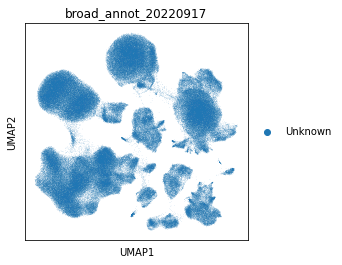

In [20]:
sc.pp.neighbors(disease_ad, use_rep="X_scANVI")
sc.tl.umap(disease_ad)
sc.pl.umap(disease_ad, color=['broad_annot_20220917'])

In [22]:
k_neighbors_transformer = weighted_knn_trainer(
        train_adata=adata,
        train_adata_emb="X_scANVI",
        label_key="broad_annot_20220917",
        n_neighbors=50,
    )

Weighted KNN with n_neighbors = 50 ... 

In [23]:
k_neighbors_transformer

KNeighborsTransformer(algorithm='brute', metric='euclidean', n_jobs=-1,
                      n_neighbors=50)

In [24]:
import pickle

In [25]:
with open(f'/home/jupyter/Annotations_v3/models/scanvi_20230126/kNN_healthy_reference_broad_annot_model.pkl', 'wb') as f:
   pickle.dump(k_neighbors_transformer, f)

In [26]:
labels, uncert = weighted_knn_transfer(
        query_adata=disease_ad,
        query_adata_emb="X_scANVI",
        label_keys="broad_annot_20220917",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = adata.obs
    )

/opt/conda/envs/scvi/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsTransformer was fitted with feature names
  warnings.warn(


finished!


In [27]:
labels

,broad_annot_20220917
index,
AAACCTGAGAGGTTAT-4918STDY7273964,B and B plasma
AAACCTGAGGCCCTCA-4918STDY7273964,T and NK cells
AAACCTGTCCAAACTG-4918STDY7273964,T and NK cells
AAACGGGAGAGCTGGT-4918STDY7273964,B and B plasma
AAACGGGCACTAAGTC-4918STDY7273964,B and B plasma
...,...
TTTGGTTTCAGGTTCA-GSM4546346,Epithelial
TTTGTCAGTCGCCATG-GSM4546346,Myeloid
TTTGTCAGTGGTGTAG-GSM4546346,Mesenchymal


In [28]:
uncert

,broad_annot_20220917
index,
AAACCTGAGAGGTTAT-4918STDY7273964,0.0
AAACCTGAGGCCCTCA-4918STDY7273964,0
AAACCTGTCCAAACTG-4918STDY7273964,0.0
AAACGGGAGAGCTGGT-4918STDY7273964,0.0
AAACGGGCACTAAGTC-4918STDY7273964,0.0
...,...
TTTGGTTTCAGGTTCA-GSM4546346,0.0
TTTGTCAGTCGCCATG-GSM4546346,0.0
TTTGTCAGTGGTGTAG-GSM4546346,0.0


In [29]:
disease_ad.obs['broad_predicted_labels'] = labels['broad_annot_20220917']
disease_ad.obs['broad_predicted_labels_uncertainty'] = uncert['broad_annot_20220917']

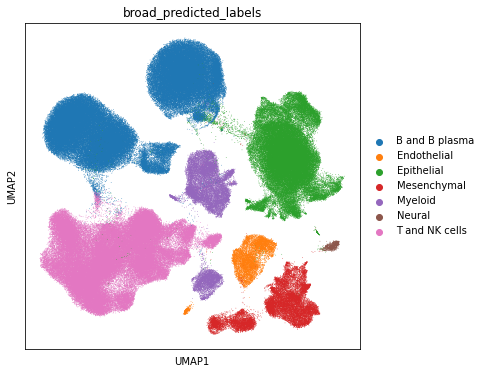

In [30]:
sk.set_figsize((6, 6))
sc.pl.umap(disease_ad, color=['broad_predicted_labels'],size=2)

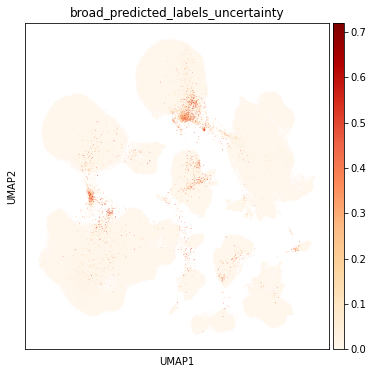

In [31]:
sk.set_figsize((6, 6))
sc.pl.umap(disease_ad, color=['broad_predicted_labels_uncertainty'],cmap='OrRd',size=2)

In [33]:
disease_ad.obs.broad_predicted_labels.to_csv('/home/jupyter/Annotations_v3/annotations/disease_broad_predicted_labels_sANVI.kNN_20230126.csv')

In [34]:
disease_ad.obs.broad_predicted_labels_uncertainty.to_csv('/home/jupyter/Annotations_v3/annotations/disease_broad_predicted_labels_uncertainty_sANVI.kNN_20230126.csv')

In [35]:
del disease_ad.obs['scrublet_done']


In [37]:
del disease_ad.obs['broad_predicted_labels_uncertainty']

In [38]:
disease_ad.write_h5ad('/home/jupyter/Annotations_v3/h5ad/disease/pooled_disease.scanvi_broad_pred_fromkNN.20230126.h5ad')